In [1]:
from tensorflow import keras
from tensorflow.keras import layers,models,optimizers,metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
train_dir = "Case2_XRay/train"
test_dir = "Case2_XRay/test"
validation_dir = "Case2_XRay/validation"

In [4]:
import os
os.listdir(train_dir)

['PNEUMONIA', 'NORMAL']

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                                 )
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 439,
    class_mode = "binary")

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 293,
    class_mode = "binary")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 293,
    class_mode = "binary")

Found 3512 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


# Model 1

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

# model.summary()

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.SensitivityAtSpecificity(0.9)]
             )

In [9]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = 8,
                              verbose = 0,
                              epochs = 10,
                              validation_data = validation_generator,
                              validation_steps = 4,
            )
model.save('case2_run_1.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [10]:
history.history.keys()

dict_keys(['loss', 'sensitivity_at_specificity', 'val_loss', 'val_sensitivity_at_specificity'])

In [11]:
acc = history.history['sensitivity_at_specificity']
val_acc = history.history['val_sensitivity_at_specificity']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

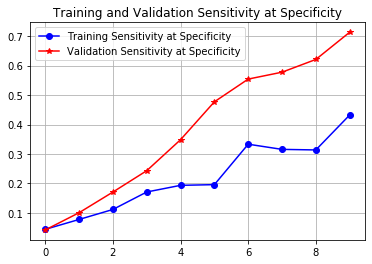

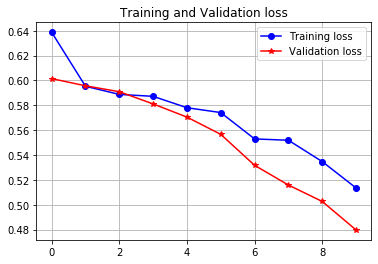

In [12]:
plt.plot(epochs,acc,'bo-',label="Training Sensitivity at Specificity")
plt.plot(epochs,val_acc,'r*-',label="Validation Sensitivity at Specificity")
plt.title('Training and Validation Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.plot(epochs,val_loss,'r*-',label="Validation loss")
plt.title('Training and Validation loss')
plt.grid()
plt.legend()

plt.show()

In [13]:
predictions = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [14]:
y_pred = 1.0*(predictions > 0.5)

In [15]:
y_true = test_generator.classes

In [16]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 34 283]
 [108 747]]
              precision    recall  f1-score   support

           0       0.24      0.11      0.15       317
           1       0.73      0.87      0.79       855

    accuracy                           0.67      1172
   macro avg       0.48      0.49      0.47      1172
weighted avg       0.59      0.67      0.62      1172



# Model 1 with weight

In [17]:
from sklearn.utils import class_weight

In [18]:
weights = class_weight.compute_class_weight('balanced',np.unique(train_generator.classes),train_generator.classes)
print(weights)

[1.85036881 0.68513461]


In [19]:
c_w = {0:weights[0],1:weights[1]}

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

# model.summary()

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.SensitivityAtSpecificity(0.9)]
             )

In [22]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = 8,
                              verbose = 0,
                              epochs = 10,
                              validation_data = validation_generator,
                              validation_steps = 4,
                              class_weight=c_w
            )
model.save('case2_run_1.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [23]:
history.history.keys()

dict_keys(['loss', 'sensitivity_at_specificity_1', 'val_loss', 'val_sensitivity_at_specificity_1'])

In [24]:
acc = history.history['sensitivity_at_specificity_2']
val_acc = history.history['val_sensitivity_at_specificity_2']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

KeyError: 'sensitivity_at_specificity_2'

In [ ]:
plt.plot(epochs,acc,'bo-',label="Training Sensitivity at Specificity")
plt.plot(epochs,val_acc,'r*-',label="Validation Sensitivity at Specificity")
plt.title('Training and Validation Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.plot(epochs,val_loss,'r*-',label="Validation loss")
plt.title('Training and Validation loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
predictions = model.predict_generator(test_generator)

In [ ]:
y_pred = 1.0*(predictions > 0.5)

In [ ]:
y_true = test_generator.classes

In [ ]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

# Model 2 Using Pretrained ConvNet (VGG16)

In [ ]:
conv_base = keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

In [ ]:
feature_batch =  conv_base.predict_generator(train_generator, 8)

In [ ]:
feature_batch_validate =  conv_base.predict_generator(validation_generator, 4)

In [ ]:
#conv_base.trainable = False

In [ ]:
#conv_base.summary()

In [ ]:
feature_batch.shape

In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=feature_batch.shape[1:]))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.SensitivityAtSpecificity(0.9)]
             )

In [ ]:
history = model.fit_generator(feature_batch,
                              steps_per_epoch = 8,
                              verbose = 0,
                              epochs = 10,
                              validation_data = feature_batch_validate,
                              validation_steps = 4,
            )
model.save('case2_run_2.h5')

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['sensitivity_at_specificity_1']
val_acc = history.history['val_sensitivity_at_specificity_1']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

In [ ]:
plt.plot(epochs,acc,'bo-',label="Training Sensitivity at Specificity")
plt.plot(epochs,val_acc,'r*-',label="Validation Sensitivity at Specificity")
plt.title('Training and Validation Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.plot(epochs,val_loss,'r*-',label="Validation loss")
plt.title('Training and Validation loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
feature_batch_test =  conv_base.predict_generator(test_generator, 10)

In [ ]:
predictions = model.predict_generator(feature_batch_test)

In [ ]:
y_pred = 1.0*(predictions > 0.5)

In [ ]:
y_true = test_generator.classes

In [ ]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))